In [1]:
import random
import numpy as np
import pandas as pd

random.seed(0)
np.random.seed(0)
pd.set_option("display.max_rows", 300)

In [2]:
HUMAN = "human"

GEMINI_10 = "gemini-1.0-pro"
GEMINI_15 = "gemini-1.5-pro-latest"

CLAUDE_SONNET = "claude-3-sonnet-20240229"
CLAUDE_OPUS = "claude-3-opus-20240229"

GPT_35 = "gpt-3.5-turbo-0125"
GPT_40 = "gpt-4-turbo-2024-04-09"

LLMS = [GEMINI_10, GEMINI_15, CLAUDE_SONNET, CLAUDE_OPUS, GPT_35, GPT_40]
AUTHORS = LLMS + [HUMAN]

REDDIT = "reddit"
HEWLETT = "hewlett"
DATASETS = [REDDIT, HEWLETT]

# Function words

In [3]:
with open("function_words/oshea.txt") as f:
    lines = f.readlines()
    fw_oseah = [line.split()[0] for line in lines]

# Z-Scores

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import word_tokenize
from scipy.spatial.distance import cdist
from sklearn.feature_extraction.text import TfidfVectorizer


class ZScoreTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, fw):
        self.fw = fw
        self.vectorizer = TfidfVectorizer(
            use_idf=False, norm=None, tokenizer=word_tokenize, token_pattern=None
        )
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        # Fit the vectorizer to the corpus
        word_counts = self.vectorizer.fit_transform(X).toarray()

        # Save the function words and their indicies if they are in the vocabulary
        self.used_fw = [word for word in self.fw if word in self.vectorizer.vocabulary_]
        self.used_fw_indices = [
            self.vectorizer.vocabulary_[word] for word in self.used_fw
        ]

        # Fit z-score scaler to the relative frequencies
        relative_freqs = word_counts / word_counts.sum(axis=1, keepdims=True)
        self.scaler.fit(relative_freqs)
        return self

    def transform(self, X):
        # Transform the corpus into word counts
        word_counts = self.vectorizer.transform(X).toarray()

        # Calculate the relative frequencies
        relative_freqs = word_counts / word_counts.sum(axis=1, keepdims=True)

        # Calculate the z-scores
        z_scores = self.scaler.transform(relative_freqs)[:, self.used_fw_indices]

        return z_scores

    def get_used_fw(self):
        return self.used_fw

# Deltas

In [5]:
def delta(z_scores, variant):
    if variant == "burrows":
        return cdist(z_scores, z_scores, metric="cityblock")
    if variant == "cosine":
        return cdist(z_scores, z_scores, metric="cosine")

    raise ValueError(f"Unknown variant: {variant}")

# Classification

In [6]:
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


def classify(df, function_words, test_prompts=None, return_df_coefs=False):
    # Train-test split
    prompt_ids = df["prompt_id"].unique().tolist()
    if not test_prompts:
        test_prompts = random.sample(prompt_ids, 2)

    df_test = df[df["prompt_id"].isin(test_prompts)].reset_index(drop=True)
    df_train = df[~df["prompt_id"].isin(test_prompts)].reset_index(drop=True)

    # Use the ZScoreTransformer to get the z-scores
    z_scores_transformer = ZScoreTransformer(function_words)
    z_scores_train = z_scores_transformer.fit_transform(df_train["text"])
    z_scores_test = z_scores_transformer.transform(df_test["text"])

    # Set up cross-validation
    train_indices_by_prompt = (
        df_train.groupby("prompt_id")
        .apply(lambda x: x.index, include_groups=False)
        .tolist()
    )
    cv_iterable = []
    for _ in range(3):
        train_indices_by_prompt = (
            train_indices_by_prompt[2:] + train_indices_by_prompt[:2]
        )
        val_indices = np.concatenate(train_indices_by_prompt[:2])
        train_indices = np.concatenate(train_indices_by_prompt[2:])
        cv_iterable.append((train_indices, val_indices))

    # Train the model using grid search
    model = GridSearchCV(
        LogisticRegression(max_iter=1000),
        param_grid={
            "C": [0.001, 0.003, 0.01, 0.03, 0.1],
            "solver": ["liblinear", "lbfgs"],
        },
        cv=cv_iterable,
        n_jobs=-1,
        refit=True,
    )

    model.fit(z_scores_train, df_train["author"])
    y_pred = model.predict(z_scores_test)

    df_test["author_pred"] = y_pred

    # print the words that were most important for the model
    if return_df_coefs:
        coefs = model.best_estimator_.coef_.squeeze()
        used_fw = z_scores_transformer.get_used_fw()
        df_coefs = pd.DataFrame({"word": used_fw, "coef": coefs})
        return df_test, df_coefs

    else:
        return df_test

In [7]:
################## TEST ##################


# df_human = pd.read_csv(f"{REDDIT}/responses/{HUMAN}.csv")
# df_human["author"] = HUMAN
# df_llm = pd.read_csv(f"{REDDIT}/responses/{GPT_35}.csv")
# df_llm["author"] = GPT_35
# df = pd.concat([df_human, df_llm]).reset_index(drop=True)

# df_test, df_coefs = classify(df, fw_oseah, return_df_coefs=True)

## Binary Classification

In [8]:
N_TRIALS = 30
fw = fw_oseah

if False:
    binary_classification = []
    for dataset in DATASETS:
        df_human = pd.read_csv(f"{dataset}/responses/{HUMAN}.csv")
        df_human["author"] = HUMAN
        for llm in LLMS:
            df_llm = pd.read_csv(f"{dataset}/responses/{llm}.csv")
            df_llm["author"] = llm
            df = pd.concat([df_human, df_llm], ignore_index=True)
            for trial in tqdm(range(N_TRIALS), desc=f"{dataset} {llm}"):
                df_test, df_coefs = classify(df, fw_oseah, return_df_coefs=True)

                binary_classification.append(
                    {
                        "dataset": dataset,
                        "llm": llm,
                        "trial": trial,
                        "df_test": df_test.to_json(orient="records"),
                        "df_coefs": df_coefs.to_json(orient="records"),
                    }
                )

    df_binary_classification = pd.DataFrame(binary_classification)
    df_binary_classification.to_csv(f"results/binary_classification.csv", index=False)

### Most important words

For each LLM and dataset, rank the words by their coefficient in the LR model (rankings are averaged over N_TRIALS trials).

In [9]:
from io import StringIO


N = 10
fw = fw_oseah

df_binary_classification = pd.read_csv("results/binary_classification.csv")

df_coefs_list = []
for _, dataset, llm, _, _, df_coefs in df_binary_classification.itertuples():
    df_coefs = pd.read_json(StringIO(df_coefs))
    df_coefs["dataset"] = dataset
    df_coefs["llm"] = llm
    df_coefs["coef_abs"] = np.abs(df_coefs["coef"])
    df_coefs["coef_sign"] = np.sign(df_coefs["coef"])

    # Add a row for each word that is in fw but not in the df
    fw_used = set(df_coefs["word"].values)
    new_rows = []
    for word in fw:
        if word not in fw_used:
            new_rows.append(
                {
                    "dataset": dataset,
                    "llm": llm,
                    "word": word,
                    "coef_abs": 0,
                    "coef_sign": 0,
                }
            )

    df_new_rows = pd.DataFrame(new_rows)
    df_coefs = pd.concat([df_coefs, df_new_rows], ignore_index=True)

    # Compute ranks (use average rank for ties)
    df_coefs["rank"] = df_coefs.groupby(["dataset", "llm"])["coef_abs"].rank(
        method="average", ascending=False
    )
    df_coefs_list.append(df_coefs)

df_coefs = pd.concat(df_coefs_list, ignore_index=True)
df_avg_ranks = df_coefs.groupby(["dataset", "llm", "word"]).mean().reset_index()
df_n_smallest = df_avg_ranks.groupby(["dataset", "llm"]).apply(
    lambda x: x.nsmallest(N, "rank"), include_groups=False
)
df_n_smallest

word      coef  coef_abs  \
dataset llm                                                              
hewlett claude-3-opus-20240229   35        because  0.320899  0.320899   
                                 238           was  0.258828  0.258828   
                                 21            and -0.258058  0.258058   
                                 113            is  0.266424  0.266424   
                                 131      moreover -0.241432  0.241432   
                                 53        despite -0.231174  0.231174   
                                 217          this  0.227098  0.227098   
                                 185            so  0.230812  0.230812   
                                 215          they  0.204929  0.204929   
                                 8             all  0.208139  0.208139   
        claude-3-sonnet-20240229 312       because  0.328370  0.328370   
                                 298           and -0.320535  0.320535   
                                 390            is  0.292764  0.292764   
                                 515           was  0.294421  0.294421   
                                 330       despite -0.266001  0.266001   
                                 308            as -0.250998  0.250998   
                                 365          here -0.278957  0.278957   
                                 494          this  0.224105  0.224105   
                                 457       several -0.231581  0.231581   
                                 492          they  0.218467  0.218467   
        gemini-1.0-pro           589       because  0.275409  0.275409   
                                 792           was  0.243452  0.243452   
                                 708            of -0.242634  0.242634   
                                 562           all  0.204325  0.204325   
                                 575           and -0.214936  0.214936   
                                 678          many  0.207117  0.207117   
                                 657           how  0.202036  0.202036   
                                 771          this  0.199591  0.199591   
                                 585            as -0.193697  0.193697   
                                 739            so  0.171841  0.171841   
        gemini-1.5-pro-latest    944            is  0.239218  0.239218   
                                 866       because  0.244786  0.244786   
                                 1075         when  0.173962  0.173962   
                                 1069          was  0.187542  0.187542   
                                 1036        there  0.173982  0.173982   
                                 1048         this  0.166831  0.166831   
                                 1016           so  0.153623  0.153623   
                                 911       further -0.150666  0.150666   
                                 839           all  0.153883  0.153883   
                                 852           and -0.157682  0.157682   
        gpt-3.5-turbo-0125       1189  furthermore -0.250748  0.250748   
                                 1129          and -0.214574  0.214574   
                                 1161      despite -0.216348  0.216348   
                                 1262           of -0.192872  0.192872   
                                 1221           is  0.189925  0.189925   
                                 1139           as -0.176259  0.176259   
                                 1143      because  0.166101  0.166101   
                                 1239     moreover -0.180463  0.180463   
                                 1325         this  0.158821  0.158821   
                                 1346          was  0.155999  0.155999   
        gpt-4-turbo-2024-04-09   1516     moreover -0.133403  0.133403   
                                 1420      because  0.123375  0.123375   
                                 1438      despite

### Word frequencies

Ratio between the frequency of each word between the LLMs and humans. 

In [10]:
# get the 10 words with the smallest average rank across all datasets and llms
N = 10
df_coefs_mult = df_coefs.copy()
n_most_important = (
    df_coefs[["word", "rank"]].groupby("word").mean().abs().sort_values("rank").head(10)
)
n_most_important

,rank
word,
was,20.738889
it,27.969444
a,30.863889
of,31.477778
as,33.419444
is,34.308333
and,35.283333
he,37.533333
because,38.863889


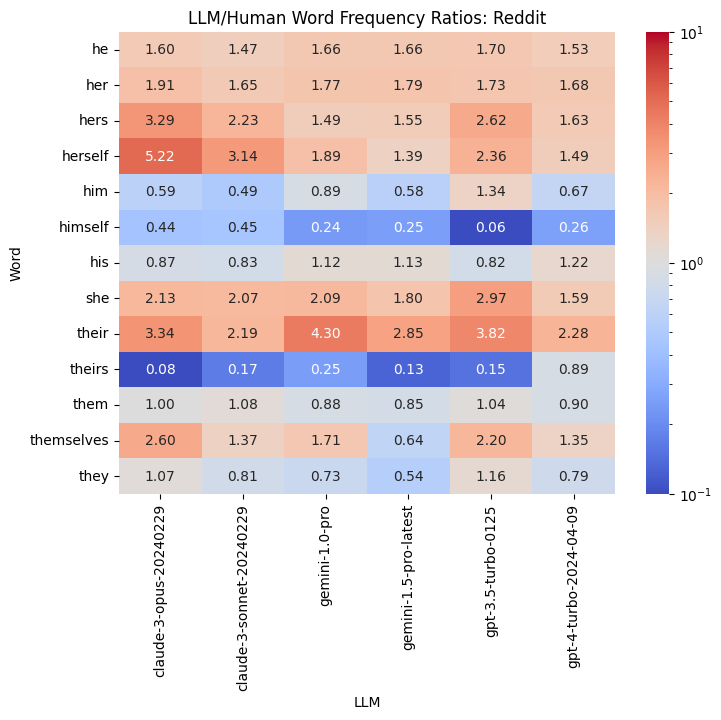

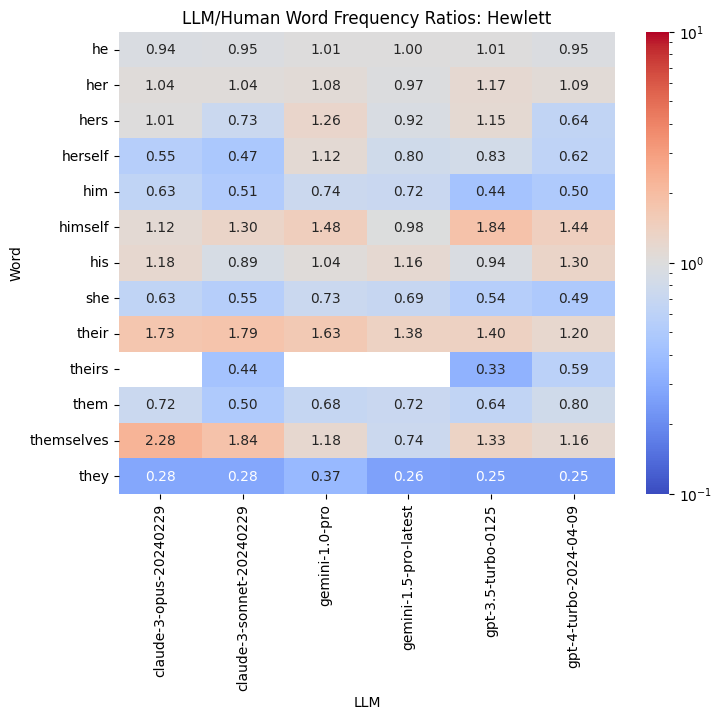

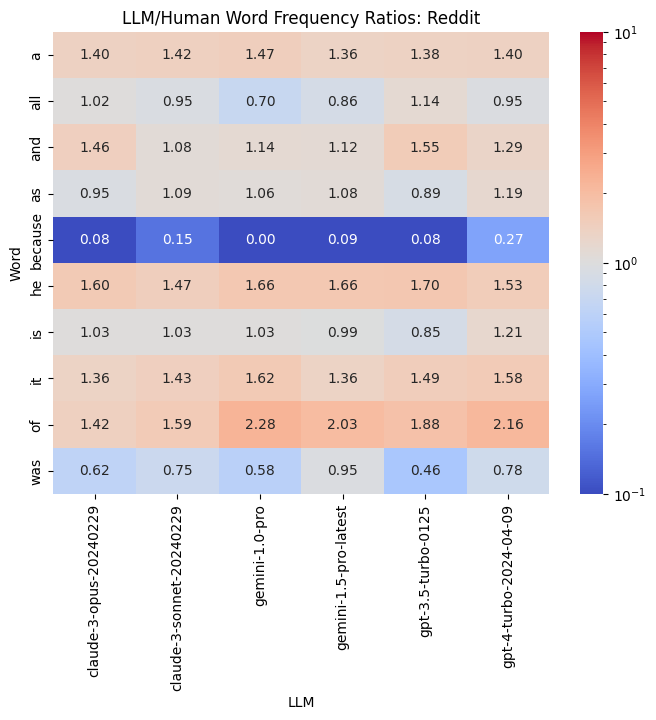

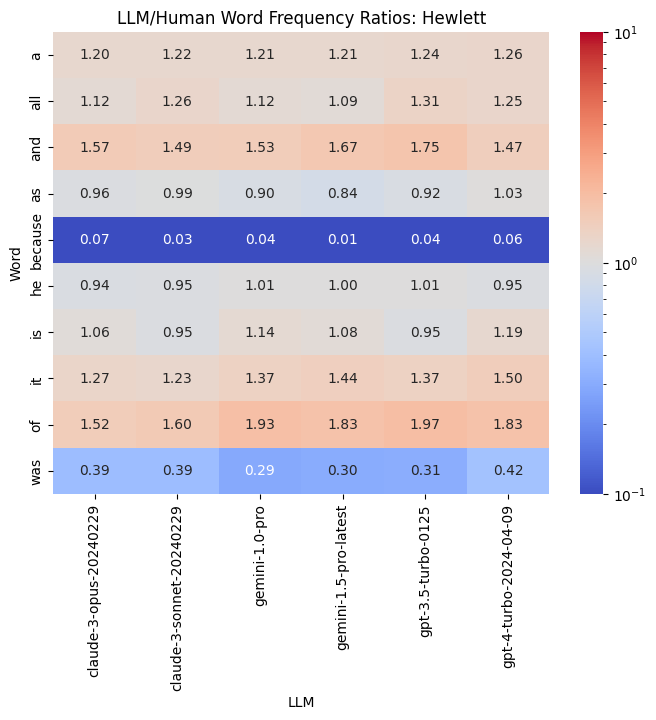

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator


pronouns = [
    "he",
    "him",
    "his",
    "himself",
    "she",
    "her",
    "hers",
    "herself",
    "they",
    "them",
    "their",
    "theirs",
    "themselves",
]

high_coef_words = n_most_important.index.tolist()

for words in [pronouns, high_coef_words]:
    # Read the data and compute ratios for each dataset
    for dataset in DATASETS:
        ratios = []
        for word in words:
            df_human = pd.read_csv(f"{dataset}/responses/{HUMAN}.csv")
            human_word_counts = df_human["text"].str.count(word)
            human_word_freq = human_word_counts / df_human["text"].apply(
                lambda x: len(x.split())
            )
            human_word_avg_freq = human_word_freq.mean()

            for llm in LLMS:
                df_llm = pd.read_csv(f"{dataset}/responses/{llm}.csv")
                llm_word_counts = df_llm["text"].str.count(word)
                llm_word_freq = llm_word_counts / df_llm["text"].apply(
                    lambda x: len(x.split())
                )
                llm_word_avg_freq = llm_word_freq.mean()

                ratio = (
                    llm_word_avg_freq / human_word_avg_freq
                    if human_word_avg_freq
                    else 100
                )
                ratios.append({"word": word, "llm": llm, "ratio": ratio})

        ratios_df = pd.DataFrame(ratios)
        pivot_df = ratios_df.pivot(index="word", columns="llm", values="ratio")
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            pivot_df,
            cmap="coolwarm",
            annot=True,
            fmt=".2f",
            norm=LogNorm(vmin=1 / 10, vmax=10),
        )
        plt.title(f"LLM/Human Word Frequency Ratios: {dataset.capitalize()}")
        plt.xlabel("LLM")
        plt.ylabel("Word")
        plt.show()

## Multiclass (all 7 authors)

In [ ]:
n_trials = 10

for dataset in ["reddit", "hewlett"]:
    dfs = []
    for author in authors:
        df = pd.read_csv(f"{dataset}_responses/{author}.csv")
        df["author"] = author
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)

    avg_conf_matrix = np.zeros((len(authors), len(authors)))
    for _ in tqdm(range(n_trials), desc=f"Running {dataset} trials"):
        df_test = classify(df, fw_oseah)
        conf_matrix = confusion_matrix(df_test["author"], df_test["y_pred"])
        avg_conf_matrix += conf_matrix

    avg_conf_matrix /= n_trials

    sns.heatmap(
        avg_conf_matrix,
        annot=True,
        cmap="YlGnBu",
        fmt=".1f",
        cbar_kws={
            "label": "Number of Predictions",
            "boundaries": np.arange(0, 201, 1),
            "ticks": np.arange(0, 201, 50),
        },
        xticklabels=authors,
        yticklabels=authors,
    )
    plt.title(f"Average Confusion Matrix: {dataset.capitalize()} dataset")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

## Pairwise with human and each LLM

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

n_trials = 10
llms = [GEMINI_10, GEMINI_15, CLAUDE_SONNET, CLAUDE_OPUS, GPT_35, GPT_40]

for dataset in ["reddit", "hewlett"]:
    df_word_ranks = []
    for llm in tqdm(llms * n_trials):
        df_llm = pd.read_csv(f"{dataset}_responses/{llm}.csv")
        df_llm["author"] = llm
        df_human = pd.read_csv(f"{dataset}_responses/{HUMAN}.csv")
        df_human["author"] = HUMAN
        df = pd.concat([df_llm, df_human], ignore_index=True)

        df_test = classify(df, fw_oseah)
        report = classification_report(
            df_test["author"], df_test["y_pred"], zero_division=0, output_dict=True
        )
        df_word_ranks.append(
            {
                "dataset": dataset,
                "llm": llm,
                "family": llm.split("-")[0],
                "accuracy": report["accuracy"],
            }
        )

    results_df = pd.DataFrame(df_word_ranks)

    plt.figure(figsize=(8, 6))
    sns.barplot(data=results_df, x="llm", y="accuracy", hue="family")
    plt.title(
        f"Human-vs-LLM Binary Classifier Accuracy: {dataset.capitalize()} dataset"
    )
    plt.ylabel("Accuracy")
    plt.xlabel("LLM")
    plt.xticks(rotation=45)
    plt.show()

# Mis-labels: GPT 3.5, human

In [ ]:
n_trials = 10

for dataset in ["reddit", "hewlett"]:
    df_human = pd.read_csv(f"{dataset}_responses/human.csv")
    df_human["author"] = HUMAN
    df_gpt_35 = pd.read_csv(f"{dataset}_responses/{GPT_35}.csv")
    df_gpt_35["author"] = GPT_35
    df = pd.concat([df_human, df_gpt_35], ignore_index=True)

    llm_predicted_human = {}
    human_predicted_llm = {}

    for _ in tqdm(range(n_trials)):
        prompts = list(range(8))
        random.shuffle(prompts)
        test_prompts_list = [prompts[:2], prompts[2:4], prompts[4:6], prompts[6:8]]

        for test_prompts in test_prompts_list:
            df_test = classify(df, function_words=fw_oseah, test_prompts=test_prompts)

            for prompt in test_prompts:
                df_human_predicted_llm = df_test[
                    (df_test["author"] == HUMAN)
                    & (df_test["y_pred"] == GPT_35)
                    & (df_test["prompt_id"] == prompt)
                ]
                if not df_human_predicted_llm.empty:
                    llm_predicted_human[prompt] = df_human_predicted_llm.iloc[0]["text"]

                df_llm_predicted_human = df_test[
                    (df_test["author"] == GPT_35)
                    & (df_test["y_pred"] == HUMAN)
                    & (df_test["prompt_id"] == prompt)
                ]
                if not df_llm_predicted_human.empty:
                    human_predicted_llm[prompt] = df_llm_predicted_human.iloc[0]["text"]

    print(f"Dataset: {dataset}")
    for prompt in range(8):
        print(f"Prompt: {prompt}")
        if prompt in llm_predicted_human:
            print(f"Human predicted LLM: {llm_predicted_human[prompt]}")
        else:
            print("Human predicted LLM: N/A")
        if prompt in human_predicted_llm:
            print(f"LLM predicted human: {human_predicted_llm[prompt]}")
        else:
            print("LLM predicted human: N/A")
        print()
    print("\n" * 3)

## GPT 3.5 Temperatures

In [ ]:
n_trials = 10
temps = [f"{0.1 * i:.1f}" for i in range(14)]

for dataset in ["reddit", "hewlett"]:
    df_word_ranks = []
    for temp in tqdm(temps * n_trials):
        df_human = pd.read_csv(f"{dataset}_responses/human.csv")
        df_human["author"] = HUMAN
        df_temp = pd.read_csv(f"{dataset}_responses/{GPT_35}_{temp}.csv")
        df_temp["author"] = GPT_35
        df = pd.concat([df_human, df_temp], ignore_index=True)

        df_test = classify(df, fw_oseah)
        report = classification_report(
            df_test["author"], df_test["y_pred"], zero_division=0, output_dict=True
        )
        df_word_ranks.append(
            {
                "dataset": dataset,
                "temp": temp,
                "accuracy": report["accuracy"],
            }
        )

    results_df = pd.DataFrame(df_word_ranks)

    plt.figure(figsize=(8, 6))
    sns.lineplot(data=results_df, x="temp", y="accuracy")
    plt.title(
        f"Human vs. GPT-3.5 Binary Classifier over a range of temperatures: {dataset.capitalize()} dataset"
    )
    plt.ylabel("Accuracy")
    plt.xlabel("Temperature")
    plt.show()

# t-SNE

## All prompts

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

for dataset in ["reddit", "hewlett"]:
    dfs = []
    for author in authors:
        df = pd.read_csv(f"{dataset}_responses/{author}.csv")
        df["author"] = author
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)

    z_scores_transformer = ZScoreTransformer(function_words=fw_oseah)
    z_scores = z_scores_transformer.fit_transform(df["text"])

    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(z_scores)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df["author"])
    plt.title(f"t-SNE Visualization of all prompts: {dataset.capitalize()} dataset")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

## Individual prompts

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

for dataset in ["reddit", "hewlett"]:
    for prompt_id in range(8):
        dfs = []
        for author in authors:
            df = pd.read_csv(f"{dataset}_responses/{author}.csv")
            df["author"] = author
            dfs.append(df)
        df = pd.concat(dfs, ignore_index=True)
        df = df[df["prompt_id"] == prompt_id]

        z_scores_transformer = ZScoreTransformer(function_words=fw_oseah)
        z_scores = z_scores_transformer.fit_transform(df["text"])

        tsne = TSNE(n_components=2, random_state=42)
        X_tsne = tsne.fit_transform(z_scores)

        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df["author"])
        plt.title(
            f"t-SNE Visualization of prompt {prompt_id} in the {dataset.capitalize()} dataset"
        )
        plt.xlabel("t-SNE Dimension 1")
        plt.ylabel("t-SNE Dimension 2")
        plt.show()